# Simulation and Visualization of Path Integral

path-integral derivation of one-dimentional diffusion process
$$
\begin{align}
P(x_N, t_N) &= \frac{1}{2\pi} \int^{\infty}_{-\infty} \rm{d}x_0 \sqrt{\frac{\pi}{D(t_N - t_0)}} 
\exp \left\{ - \frac{[\ (x_N - x_0) - u(t_N - t_0) \ ]^2}{4D(t_N-t_0)} \right\} \delta(x_0-x_I) \nonumber \\
            &= \sqrt{\frac{1}{4\pi D(t_N - t_0)}} \exp \left\{ - \frac{[\ (x_N - x_I) - u(t_N - t_0) \ ]^2}{4D(t_N-t_0)} \right\} \nonumber
\end{align}
$$

$\mu$ : $$ x_I + u(t_N - t_0) $$

$\sigma$ : $$ \sqrt{2 D (t_N - t_0) } $$

In [17]:
# basic
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# animation
from matplotlib import patches
from matplotlib.animation import ArtistAnimation
from IPython import display

In [18]:
# analytical solution
def P(
      xn_xi: np.ndarray,
      tn_t0: float, 
      D: float,
      u: float,
    ):
    """
    xn_xi : x_N - x_I [m]
    tn_t0 : t_N - t_0 [sec]
    D : diffusion coefficient [m^2/s]
    u : velocity [m/s]
    """

    p = np.sqrt(1.0 / (4.0 * np.pi * D * tn_t0) ) *\
        np.exp(-((xn_xi) - u * (tn_t0))**2 / (4.0 * D * tn_t0))

    return p

$$
P(x_i, t+\Delta t) = \sqrt{\frac{1}{4\pi D \Delta t}} \sum_j \exp \left[-  \frac{(x_i - x_j - u\Delta t)^2}{4D \Delta t} \right] \Delta x \cdot P(x_j, t)
$$

In [19]:
# numerical solution
def PathIntegralP(
      P_prev: np.ndarray,
      x_xi: np.ndarray,
      delta_t: float,
      D: float,
      u: float,
    ):
    """path-integral
    P_prev : previous probability 
    delta_t: descritized time step [s]  
    D : diffusion coefficient [m^2/s]
    u : velocity [m/s]
    """
    xdim = x_xi.size
    delta_x = (x_xi[-1] - x_xi[0]) / xdim

    A = np.zeros((xdim,xdim))
    for k in range(xdim):
      ak = -np.arange(-k, -k + xdim) # -k ... -k + xdim-1
      A[k] = ak * delta_x
    A -= u*delta_t

    Pc = np.sqrt(1.0 / (4.0 * np.pi * D * delta_t)) * np.exp(- A**2 / (4.0 * D * delta_t) ) * delta_x
    P_next = Pc @ P_prev

    return P_next

$$
    P(x_i, y_j, t+\Delta t) 
    = 
    \sqrt{\frac{1}{4\pi D \Delta t}} 
    \sum_k 
    \exp \left[-  \frac{(x_i - x_k - u_x\Delta t)^2}{4D \Delta t} \right] 
    \Delta x 
    \cdot
    \sqrt{\frac{1}{4\pi D \Delta t}} 
    \sum_l
    \exp \left[-  \frac{(y_j - y_l - u_y\Delta t)^2}{4D \Delta t} \right] 
    \Delta y 
    \cdot 
    P(x_k, y_l, t)
$$

In [ ]:
xdim = 3
ydim = 4
A_large = np.zeros((2*xdim-1, 2*ydim-1))
for x in range(1, xdim):
    for y in range(1, ydim):
        distance = np.sqrt(x**2+y**2)
        i = 
        A_large[i+xdim-1, j+ydim-1] = distance
        A_large[i+xdim-1, j+ydim-1] = distance

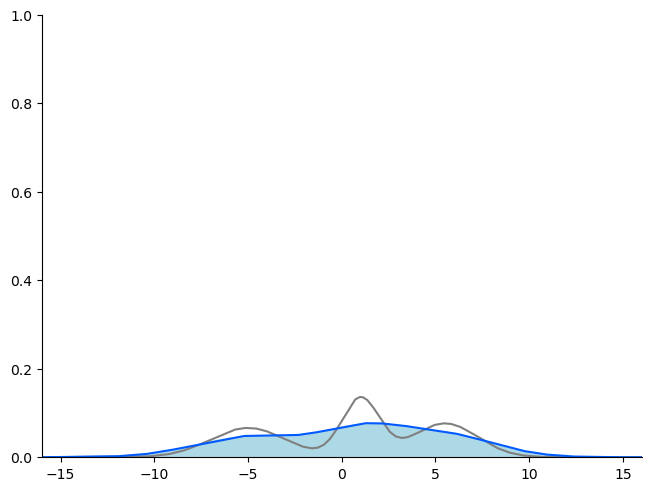

In [4]:
# simulation params
num_of_samples = 401
xmin, xmax = -16.0, +16.0 # [m]

xi = 1.0 # [m]
x = np.linspace(xmin, xmax, num_of_samples)
x_xi = x - np.ones(num_of_samples) * xi
t0 = 0.0 # [sec]
t = 0.1 # [sec]
t_t0 = t - t0
delta_t = 0.1 # [s]
D = 1.0 # [m^2/s]
u = 0.0 # [m/s]

# set prior distribution as you like
## ex. 1
# Pnow = P(x_xi, 2.0, D=D, u=-3.0) + P(x_xi, 1.0, D=D, u=1.0)
# Pnow /= 2 # standardization
## ex. 2
P_prev = P(x_xi, 2.0, D=D, u=-3.0) + P(x_xi, 0.5, D=D, u=0.0) + P(x_xi, 1.5, D=D, u=3.0)
P_prev /= 3 # standardization

# make figure
fig, ax = plt.subplots()

# layout settings
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# set axis limits
ax.set_xlim(xmin, xmax)
ax.set_ylim( 0,  1.0)

# draw P_prev
ax.plot(x, P_prev, color="gray")

# draw P(x) with fill & plot
ax.fill_between(x, PathIntegralP(P_prev, x_xi, delta_t*20, D, u), fc='#add8e6')
ax.plot(x, PathIntegralP(P_prev, x_xi, delta_t*20, D, u), color="#005AFF")

# show plot
plt.show()

/var/folders/9j/hrz2cfzj42n83g5gn4w9twy00000gn/T/ipykernel_25507/5086503.py:36: UserWarning: The figure layout has changed to tight
  fig.tight_layout()

KeyboardInterrupt



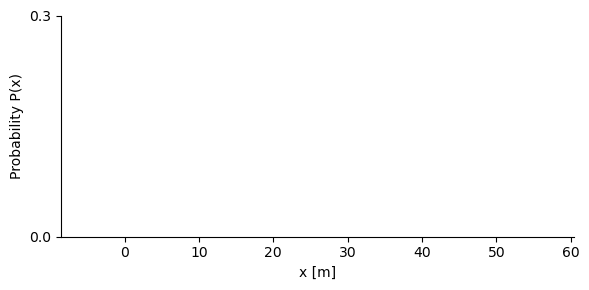

In [5]:
# prepare figure
fig, ax = plt.subplots(1, 1, figsize=(6,3))

# simulation params
t0 = 0.0 # [sec]
t = 5.0 #10.0 # [sec]
D = 1.0 # [m^2/s]
u = 10.0 # [m/s]
xi = 1.0 # [m]
dt = 0.05 # [s]
dx = 0.05 # [m]

# simulation settings
num_sigma = 3 # x range to consider in simulation
t_t0 = t - t0
sim_steps = int(t_t0 // dt) # [step]
xlim0, xlimn = xi-np.sign(u)*np.sqrt(2*D*t)*num_sigma, xi+u*t+np.sign(u)*np.sqrt(2*D*t)*num_sigma
xmin, xmax = min(xlim0, xlimn), max(xlim0, xlimn)
num_of_samples = int((xmax-xmin)/dx)
x = np.linspace(xmin, xmax, num_of_samples)
x_xi = x - np.ones(num_of_samples) * xi

# set prior distribution as you like
Pnow = P(x_xi, 2.0, D=D, u=-3.0) + P(x_xi, 0.5, D=D, u=0.0) + P(x_xi, 1.5, D=D, u=3.0)
Pnow /= 3 # standardization

# graph layout settings
ax.set_xlabel("x [m]")
ax.set_ylabel("Probability P(x)")
ax.set_xlim(xmin, xmax)
ymax = np.max(Pnow)*1.5
ax.set_ylim(0, ymax)
ax.set_yticks([0, 0.3])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.tight_layout()

# simulation loop
frames = []
for i in range(1, sim_steps):
    current_t = t0 + i * dt
    Pnow = PathIntegralP(Pnow, x_xi, dt, D, u)
    frame = ax.plot(x, Pnow, color="#005AFF")
    frame += [ax.fill_between(x, Pnow, fc='#add8e6')]
    text = "Time t = {t:>4.1f} [s]".format(t=current_t)
    frame += [ax.text(0.5, 0.9, text, ha='center', transform=ax.transAxes, fontsize=10, fontfamily='monospace')]
    frames.append(frame)

# show animation
ani = ArtistAnimation(fig, frames, interval=dt*1000)
html = display.HTML(ani.to_jshtml())
display.display(html)
plt.close()

# save animation
ani.save("path_integral_diffusion.mp4", writer="ffmpeg")